In [1]:
import os
import json
import csv
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

## Essential Dictionaries / lists

In [2]:
directory = '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt'

#get directories without hidden files
directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
directories.sort()

#Setup dictionary to collect file names
all_file_names = {}

#Identify all file names
for d in directories:
    #get file names without hidden files
    files = [f for f in os.listdir(os.path.join(directory, d)) if os.path.isfile(os.path.join(directory, d, f))]
    files.sort()
    all_file_names[d] = files

In [3]:
#Count the number of videos in each video type
#Determined by checking last number string on each image and
#checking if it matches '0001'
num_videos = {}
first_img_indexes = {}

for d in directories:
    video_count = 0
    num_images = len(all_file_names[d])
    for i in range(num_images):
        if all_file_names[d][i].split('.')[0].split('_')[-1] == '0001':
            video_count += 1
    num_videos[d] = video_count

In [4]:
#Print out summary results
print(f"{'dance':<9} | {'Num Images':<10} | {'Num Videos':<9}")
print("-"*35)
for k,v in all_file_names.items():
    print(f'{k:<9} | {len(v):<10} | {num_videos[k]}')

dance     | Num Images | Num Videos
-----------------------------------
ballet    | 22410      | 89
break     | 25622      | 95
cha       | 28098      | 98
flamenco  | 24755      | 88
foxtrot   | 23738      | 79
jive      | 29100      | 106
latin     | 24460      | 90
pasodoble | 26607      | 98
quickstep | 24036      | 82
rumba     | 27262      | 94
samba     | 25807      | 96
square    | 27453      | 97
swing     | 26337      | 95
tango     | 24020      | 80
tap       | 28541      | 95
waltz     | 24380      | 80


In [5]:
# getting the names of videos and adding them to a dictionary under the dance style they belong to
# video_names = {key=DanceStyle : value=[VideoName0, VideoName1, etc.]}
video_names = {}
for d in directories:
    dance_names = []
    for x in all_file_names[d]:
        sliced_name = x[0:-9]
        if sliced_name not in dance_names:
            dance_names.append(sliced_name)
    video_names[d] = dance_names

In [6]:
# Validation: should return 89
print(len(video_names['ballet']))

89


## Function: Number of people in a frame

In [7]:
def person_count(file_name):
    '''Input a JSON file and get the number of people in each frame. '''
    f = open(file_name, "r")
    j = json.load(f)
    f.close

    people_count = len(j)

    return people_count

In [8]:
# Testing results, should return 5
peeps = person_count('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-5Yp-vToI2E_016_0001.json')
peeps

5

## Functions: Get body position & Body parts

In [9]:
def get_body_position_info(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close
    people= []

    for i,person in enumerate(j):
        #Set up list to collect person's body location
        person_i = []
        count = 0

        #add each body part position to the list
        for body_part in person:
            count+=1
            if count == 1: continue
            else: person_i.append(body_part[1])

        #Append entire list to list of people
        people.append(person_i)

    return people

In [10]:
def get_body_part_labels(file_name):
    '''Input a JSON file and get the body position of each person.  Outer list is
    list of people.  Inner list is x,y position of each body part for that person'''
    f = open(file_name, "r")
    j = json.load(f)
    f.close()
    
    # Extract body part labels from the first person entry in the JSON file
    body_part_labels = [body_part[0] for body_part in j[0][1:]]
   
    return body_part_labels

In [11]:
# creating a dictionary to hold each video and all of its frames {video_name: [frame1, frame2, etc.]}
videos_ballet = {}
videos_tap = {}
videos_latin = {}

# looping through all dance styles
for d in directories:
    # dict to store avg number of people per video for 1 dance style
    vid_dict = {}
    
    if d == 'ballet':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct < 2 and ct > 0:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_ballet = vid_dict

    if d == 'tap':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct < 2 and ct > 0:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_tap = vid_dict

    if d == 'latin':
    
        # looping through each video name
        for p in video_names[d]:
            # list to store num people for each frame for 1 video
            file_list = []
            
            # looping through the files for the corresponding dance style to match the video title
            for f in all_file_names[d]:
                if f.startswith(p):
                    file_path = os.path.join(directory, d, f)
                    ct = person_count(file_path)
                    if ct < 2 and ct > 0:
                        file_list.append(file_path)
                    #else:
                    #    file_list.append(np.NaN)
    
            
            vid_dict[p] = file_list
        videos_latin = vid_dict


print("Number of selected files for ballet:", len(videos_ballet))
print("Number of selected files for tap:", len(videos_tap))
print("Number of selected files for tap:", len(videos_latin))

Number of selected files for ballet: 89
Number of selected files for tap: 95
Number of selected files for tap: 90


In [12]:
# making sure no null frames are present
videos_ballet = {k: v for k, v in videos_ballet.items() if len(v) != 0}
videos_tap = {k: v for k, v in videos_tap.items() if len(v) != 0}
videos_latin = {k: v for k, v in videos_latin.items() if len(v) != 0}

print("New Number of selected files for ballet:", len(videos_ballet))
print("New Number of selected files for tap:", len(videos_tap))
print("New Number of selected files for tap:", len(videos_latin))

New Number of selected files for ballet: 71
New Number of selected files for tap: 38
New Number of selected files for tap: 53


### Instead of turning the dict into a dataframe, we can just iterate through the dict and pull a certain count of vids and append that way

In [13]:
# I will worry about flattening later

X_train_ballet = []
X_test_ballet = []
X_train_tap = []
X_test_tap = []
X_train_latin = []
X_test_latin = []

# append 80% of keys (80% of the key count, but append the contents) to a list of X_train_ballet
split_b = int((len(videos_ballet)*80)/100)
b = 0

# v is the name of the video
# f is the files (with paths) in the video
for v, f in videos_ballet.items():
    if b <= split_b:
        b += 1
        X_train_ballet.append(f)
    else:
        X_test_ballet.append(f)

split_t = int((len(videos_tap)*80)/100)
t = 0

for v, f in videos_tap.items():
    if t <= split_t:
        t += 1
        X_train_tap.append(f)
    else:
        X_test_tap.append(f)

split_l = int((len(videos_latin)*80)/100)
l = 0

for v, f in videos_latin.items():
    if l <= split_l:
        l += 1
        X_train_latin.append(f)
    else:
        X_test_latin.append(f)

print('Ballet train set length:',len(X_train_ballet))
print('Ballet test set length:',len(X_test_ballet))
print('Tap train set length:',len(X_train_tap))
print('Tap test set length:',len(X_test_tap))
print('Latin train set length:',len(X_train_latin))
print('Latin test set length:',len(X_test_latin))

Ballet train set length: 57
Ballet test set length: 14
Tap train set length: 31
Tap test set length: 7
Latin train set length: 43
Latin test set length: 10


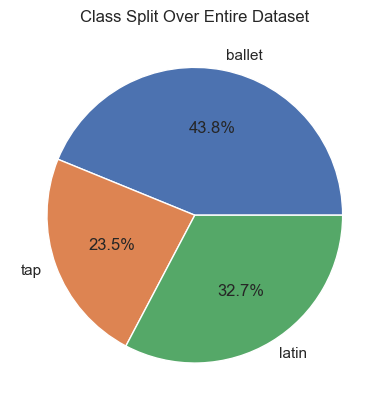

In [14]:
# sample size of data
l = np.array([len(videos_ballet), len(videos_tap), len(videos_latin)])
labels = ["ballet", "tap", "latin"]

plt.pie(l, labels = labels, autopct='%1.1f%%')
plt.title('Class Split Over Entire Dataset')
plt.show()

In [15]:
# combine arrays
X_train_files = X_train_ballet + X_train_tap + X_train_latin
X_test_files = X_test_ballet + X_test_tap + X_test_latin

## Collect Temporal Information

In [107]:
def get_temporal_position_info(file_name_orig, file_name_future):
    '''Input a JSON file and a JSON file 't' frames away.  Function returns
    a vector distance calculation for motion of each body part between
    the two frames.  Only works with one person in the frame'''
    f_0 = open(file_name_orig, "r")
    f_t = open(file_name_future, "r")
    j_0 = json.load(f_0)
    j_t = json.load(f_t)
    f_0.close
    f_t.close
    time_0 = []
    time_t = []

    #add each body part position at time 0
    for i,body_part in enumerate(j_0[0]):
        if i == 0: continue
        else: time_0.append(body_part[1])
    #add each body part position at time t
    for i,body_part in enumerate(j_t[0]):
        if i == 0: continue
        else: time_t.append(body_part[1])

    #Perform element-wise calculation with np arrays
    time_0_array = np.array(time_0)
    time_t_array = np.array(time_t)
    result_array = (time_t_array - time_0_array)
    result_list = result_array.tolist()

    return [result_list]

In [108]:
get_body_position_info(X_train_files[0][5])

[[[1020.0453491210938, 536.8102416992188],
  [1035.03515625, 522.8208618164062],
  [1016.048095703125, 522.8208618164062],
  [1072.009765625, 535.81103515625],
  [1012.0508422851562, 537.8095092773438],
  [1103.9879150390625, 605.7579345703125],
  [994.0631713867188, 612.7526245117188],
  [1147.957763671875, 669.7094116210938],
  [999.0597534179688, 712.6768188476562],
  [1241.8934326171875, 649.724609375],
  [949.0939331054688, 641.7306518554688],
  [1102.988525390625, 747.6502685546875],
  [1031.037841796875, 757.6427001953125],
  [1143.9605712890625, 862.5631103515625],
  [1009.0529174804688, 813.6002807617188],
  [1192.927001953125, 998.4600219726562],
  [949.0939331054688, 991.46533203125]]]

In [109]:
get_temporal_position_info(X_train_files[0][5], X_train_files[0][16])

[[[-63.16339111328125, -132.7991943359375],
  [-77.15374755859375, -139.80133056640625],
  [-25.18548583984375, -155.79486083984375],
  [-102.13519287109375, -152.79150390625],
  [-44.1751708984375, -147.79278564453125],
  [-51.16064453125, -196.7489013671875],
  [-30.1851806640625, -152.76422119140625],
  [-19.173828125, -279.69268798828125],
  [-52.172119140625, -174.719970703125],
  [-36.1533203125, -270.7034606933594],
  [-26.192626953125, -53.79400634765625],
  [-5.1868896484375, -104.73583984375],
  [1.80078125, -99.734375],
  [-15.1766357421875, -59.71337890625],
  [8.7943115234375, 11.24053955078125],
  [-46.1533203125, -39.67340087890625],
  [51.762939453125, -5.68963623046875]]]

In [110]:
def get_future_file_name(file, n_frames_later):
    '''Inputs a file name string and outputs the corresponding file name
    string set to n frames later'''
    underscore_split = file.split('_')
    #isolate the nubmer and update with future frame number
    updated_num = int(underscore_split[-1].split('.')[0]) + n_frames_later
    number_str = str(updated_num).zfill(4)+ '.json'
    #combine strings into full file name
    underscore_split[-1] = number_str
    updated_file_name = '_'.join(underscore_split)

    return updated_file_name

In [111]:
print(X_train_files[0][15])
print("Sum of files in X_train_ballet = videos: ", len(X_train_ballet))
print("Sum of files in X_train_tap = videos: ", len(X_train_tap))
print("Sum of files in X_train_latin = videos: ", len(X_train_latin))
print("Sum of files in X_train = videos: ", len(X_train_files))
print("Sum of files in X_train[0]: ", len(X_train_files[0]))
print("Sum of files in X_train[1]: ", len(X_train_files[1]))
print("Sum of files in X_train[130]: ", len(X_train_files[130]))

/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0089.json
Sum of files in X_train_ballet = videos:  57
Sum of files in X_train_tap = videos:  31
Sum of files in X_train_latin = videos:  43
Sum of files in X_train = videos:  131
Sum of files in X_train[0]:  62
Sum of files in X_train[1]:  168
Sum of files in X_train[130]:  3


In [112]:
# I want to find the total number of images for ballet, tap and latin training videos respectively
ballet_img_ct = 0
tap_img_ct = 0
latin_img_ct = 0

for video in X_train_ballet:
    for img in video:
        ballet_img_ct+=1

for video in X_train_tap:
    for img in video:
        tap_img_ct+=1

for video in X_train_latin:
    for img in video:
        latin_img_ct+=1 

print(ballet_img_ct)
print(tap_img_ct)
print(latin_img_ct)

7196
5587
4452


In [113]:
get_future_file_name(X_train_files[0][15], 10)

'/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0099.json'

Current Status:
Once I get code from Shruti that isolates the frames that have reference frames n frames later with one person
- I have code to get the new file name
- I have function to calculate the vector distance 
    - returns a list the same way that the original body positions are returned

Things to do:
- verify code that creates numpy array that contains all the termporal information for train and test data
- normalize the temporal information based on the width and height of the original frame
- concatenate all this into one giant array for training (34 + 34 columns)
- Run through model to see improvement

In [114]:
# SHRUTI ADDING CODE
def check_file_exists(file_list, target_path):
    for path in file_list:
        if path == target_path:
            return True
    return False

In [115]:
video_0_files = X_train_ballet[0]

for file_path in video_0_files:
    # if os.path.exists(get_future_file_name(file_path, 10)):
    if check_file_exists(video_0_files, get_future_file_name(file_path, 10)):
        print(file_path)
    #     print(get_future_file_name(file_path, 10))
    # else:
    #     print(False)

/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0075.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0077.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0079.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0080.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0081.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0082.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0083.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0084.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0085.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0086.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0087.json
/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjX

In [116]:
# Just collecting Ballet Filtered Files - these are files that have a corresponding future file for us to collect temporal information from

X_train_ballet_filtered = []
ballet_filtered_img_ct = 0

for video_files in X_train_ballet:
    filtered_ballet_video_files = []
    for file_path in video_files:
        if check_file_exists(video_files, get_future_file_name(file_path, 10)):
            # Add the file path to the filtered list if the future file exists
            filtered_ballet_video_files.append(file_path)
            X_train_ballet_filtered.append((file_path, get_future_file_name(file_path, 10)))
    ballet_filtered_img_ct+=len(filtered_ballet_video_files)

print(ballet_filtered_img_ct)
print(X_train_ballet_filtered)
print(len(X_train_ballet_filtered))

5751
[('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0075.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0085.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0077.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0087.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0079.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0089.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0080.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0090.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0081.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0091.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/-sEgjXxjxIw_102_0082.json', '/Users/Shruti/

In [117]:
# Just collecting Tap Filtered Files - these are files that have a corresponding future file for us to collect temporal information from

X_train_tap_filtered = []
tap_filtered_img_ct = 0

for video_files in X_train_tap:
    filtered_tap_video_files = []
    for file_path in video_files:
        if check_file_exists(video_files, get_future_file_name(file_path, 10)):
            # Add the file path to the filtered list if the future file exists
            filtered_tap_video_files.append(file_path)
            X_train_tap_filtered.append((file_path, get_future_file_name(file_path, 10)))
    tap_filtered_img_ct+=len(filtered_tap_video_files)

print(tap_filtered_img_ct)
print(X_train_tap_filtered)
print(len(X_train_tap_filtered))

4951
[('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0001.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0011.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0002.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0012.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0003.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0013.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0004.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0014.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0005.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0015.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0006.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose

In [118]:
# Just collecting Latin Filtered Files - these are files that have a corresponding future file for us to collect temporal information from

X_train_latin_filtered = []
latin_filtered_img_ct = 0

for video_files in X_train_latin:
    filtered_latin_video_files = []
    for file_path in video_files:
        if check_file_exists(video_files, get_future_file_name(file_path, 10)):
            # Add the file path to the filtered list if the future file exists
            filtered_latin_video_files.append(file_path)
            X_train_latin_filtered.append((file_path, get_future_file_name(file_path, 10)))
    latin_filtered_img_ct+=len(filtered_latin_video_files)

print(latin_filtered_img_ct)
print(X_train_latin_filtered)
print(len(X_train_latin_filtered))

2861
[('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0005.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0015.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0011.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0021.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0013.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0023.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0015.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0025.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0017.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0027.json'), ('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/01f-oLGZv1s_017_0019.json', '/Users/Shruti/Downloads/D

In [119]:
# TRAIN SET
# Collecting Filtered Files - these are files that have a corresponding future file for us to collect temporal information from
# The final result is stored in a list of tuples of valid (file, future file) pairs

X_train_filtered = []
train_filterd_img_ct = 0

for video_files in X_train_files:
    filtered_video_files = []
    for file_path in video_files:
        if check_file_exists(video_files, get_future_file_name(file_path, 10)):
            # Add the file path to the filtered list if the future file exists
            filtered_video_files.append(file_path)
            X_train_filtered.append((file_path, get_future_file_name(file_path, 10)))
    train_filterd_img_ct+=len(filtered_video_files)

print(train_filterd_img_ct)
print(X_train_filtered[1000])
print(X_train_filtered[6000])
print(X_train_filtered[12000])
print(len(X_train_filtered))

13553
('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/44CFZ1pz_SM_020_0221.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/ballet/44CFZ1pz_SM_020_0231.json')
('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0260.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/tap/-ZxOm8B-BX4_020_0270.json')
('/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/Wtjfwu3SDvE_230_0217.json', '/Users/Shruti/Downloads/Dance_Dataset/densepose/txt/latin/Wtjfwu3SDvE_230_0227.json')
13553


In [130]:
# TEST SET
# Collecting Filtered Files - these are files that have a corresponding future file for us to collect temporal information from
# The final result is stored in a list of tuples of valid (file, future file) pairs

X_test_filtered = []
test_filterd_img_ct = 0

for video_files in X_test_files:
    filtered_video_files = []
    for file_path in video_files:
        if check_file_exists(video_files, get_future_file_name(file_path, 10)):
            # Add the file path to the filtered list if the future file exists
            filtered_video_files.append(file_path)
            X_test_filtered.append((file_path, get_future_file_name(file_path, 10)))
    test_filterd_img_ct+=len(filtered_video_files)

print(test_filterd_img_ct)
print(len(X_test_filtered))

2793
2793


In [131]:
# Testing logic for iterating through the tuples (file, future file) to get body positions for the temporal associations

for pair in X_train_filtered:
    print("Body Positions of Current File")
    print(get_body_position_info(pair[0]))
    print("Body Positions of Respective Future File")
    print(get_temporal_position_info(pair[0], pair[1]))
    print()
    break

Body Positions of Current File
[[[969.1967163085938, 620.8961181640625], [980.1813354492188, 601.9074096679688], [968.1981201171875, 603.9061889648438], [1021.1240844726562, 603.9061889648438], [968.1981201171875, 605.905029296875], [1056.0751953125, 660.8724975585938], [970.1953125, 662.8712768554688], [1070.0556640625, 727.8328247070312], [987.1715698242188, 755.8162231445312], [1077.0458984375, 749.8197631835938], [1031.110107421875, 757.8150634765625], [1096.019287109375, 789.7960815429688], [1019.1268920898438, 793.7937622070312], [1140.95654296875, 872.7470092773438], [919.2665405273438, 880.7422485351562], [1193.8824462890625, 987.6788940429688], [895.300048828125, 1005.6682739257812]]]
Body Positions of Respective Future File
[[[184.91583251953125, 5.49676513671875], [-19.691162109375, -231.3623046875], [190.90478515625, 13.4920654296875], [-36.68060302734375, -198.38189697265625], [7.26287841796875, -196.38311767578125], [-8.75439453125, -210.37493896484375], [0.275390625, -19

## Pull Test/Train Data From JSON Files

In [164]:
# Initialize lists to store feature data and corresponding labels
train_feature_data = []
train_feature_data_flattened = []

train_temporal_data = []
train_temporal_data_flattened = []

train_labels = []

# Iterate through the filtered training set which is a list of tuples of respective (file, future temporal file) pairings
for pair in X_train_filtered:
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(pair[0])
        train_feature_data.append(body_positions)

        #Getting temporal information
        # future_file_name = get_future_file_name(f, 10)
        temporal_info = get_temporal_position_info(pair[0], pair[1])
        train_temporal_data.append(temporal_info)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
        flattened_temporal_positions = [coord for point in temporal_info for coord in point]
    
        # Append the flattened positions to the feature data list
        train_feature_data_flattened.append(flattened_positions)
        train_temporal_data_flattened.append(flattened_temporal_positions)
        
        # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in pair[0]:
            label = 'ballet'
        elif 'tap' in pair[0]:
            label = 'tap'
        elif 'latin' in pair[0]:
            label = 'latin'
        else:
            label = 'unknown'
        train_labels.append(label)


In [165]:
# Convert the training feature data and labels into numpy arrays
X_train = np.array(train_feature_data)
X_train_flattened = np.array(train_feature_data_flattened)
y_train = np.array(train_labels)

X_train_temporal = np.array(train_temporal_data)
X_train_temporal_flattened = np.array(train_temporal_data_flattened)
y_train_temporal = np.array(train_labels)

print("Number of frames (rows) in X_train:", len(X_train_flattened))
print("Number of features (columns) in X_train:", len(X_train_flattened[0]))
print("Number of labels in y_train:", len(y_train))
print()
print("Number of frames (rows) in X_train_temporal:", len(X_train_temporal_flattened))
print("Number of features (columns) in X_train_temporal:", len(X_train_temporal_flattened[0]))
print("Number of labels in y_train_temporal:", len(y_train_temporal))

Number of frames (rows) in X_train: 13553
Number of features (columns) in X_train: 17
Number of labels in y_train: 13553

Number of frames (rows) in X_train_temporal: 13553
Number of features (columns) in X_train_temporal: 17
Number of labels in y_train_temporal: 13553


In [189]:
# repeating above steps for test data

# Initialize lists to store feature data and corresponding labels for the testing set
test_feature_data = []
test_feature_data_flattened = []

test_temporal_data = []
test_temporal_data_flattened = []

test_labels = []

# Iterate through the filtered training set which is a list of tuples of respective (file, future temporal file) pairings
for pair in X_test_filtered:
        
        #getting body positions for people in frame
        body_positions = get_body_position_info(pair[0])
        test_feature_data.append(body_positions)

        #Getting temporal information
        # future_file_name = get_future_file_name(f, 10)
        temporal_info = get_temporal_position_info(pair[0], pair[1])
        test_temporal_data.append(temporal_info)
    
        # Flatten the list of x, y positions
        flattened_positions = [coord for point in body_positions for coord in point]
        flattened_temporal_positions = [coord for point in temporal_info for coord in point]
    
        # Append the flattened positions to the feature data list
        test_feature_data_flattened.append(flattened_positions)
        test_temporal_data_flattened.append(flattened_temporal_positions)
        
        # Determine the label based on the file path (e.g., ballet or tap)
        if 'ballet' in pair[0]:
            label = 'ballet'
        elif 'tap' in pair[0]:
            label = 'tap'
        elif 'latin' in pair[0]:
            label = 'latin'
        else:
            label = 'unknown'
        test_labels.append(label)

# Convert the testing feature data and labels into numpy arrays
X_test = np.array(test_feature_data)
X_test_flattened = np.array(test_feature_data_flattened)
y_test = np.array(test_labels)

X_test_temporal = np.array(test_temporal_data)
X_test_temporal_flattened = np.array(test_temporal_data_flattened)
y_test_temporal = np.array(test_labels)

print("Number of frames (rows) in X_test:", len(X_test_flattened))
print("Number of features (columns) in X_test:", len(X_test_flattened[0]))
print("Number of labels in y_test:", len(y_test))
print()
print("Number of frames (rows) in X_test_temporal:", len(X_test_temporal_flattened))
print("Number of features (columns) in X_test_temporal:", len(X_test_temporal_flattened[0]))
print("Number of labels in y_test_temporal:", len(y_test_temporal))


Number of frames (rows) in X_test: 2793
Number of features (columns) in X_test: 17
Number of labels in y_test: 2793

Number of frames (rows) in X_test_temporal: 2793
Number of features (columns) in X_test_temporal: 17
Number of labels in y_test_temporal: 2793


# Random Forest Model Construction

In [190]:
# then train and do the model

# prepping the model 
# Define the body part labels
body_part_labels = [
    "nose_x", "nose_y", 
    "left_eye_x", "left_eye_y", 
    "right_eye_x", "right_eye_y", 
    "left_ear_x", "left_ear_y", 
    "right_ear_x", "right_ear_y", 
    "left_shoulder_x", "left_shoulder_y", 
    "right_shoulder_x", "right_shoulder_y", 
    "left_elbow_x", "left_elbow_y", 
    "right_elbow_x", "right_elbow_y", 
    "left_wrist_x", "left_wrist_y", 
    "right_wrist_x", "right_wrist_y", 
    "left_hip_x", "left_hip_y", 
    "right_hip_x", "right_hip_y", 
    "left_knee_x", "left_knee_y", 
    "right_knee_x", "right_knee_y", 
    "left_ankle_x", "left_ankle_y", 
    "right_ankle_x", "right_ankle_y"
]

# Create a dictionary to map body part labels to column indices
body_part_mapping = {label: i for i, label in enumerate(body_part_labels)}

# Access the x-coordinate of the left eye for all frames
left_eye_x_coordinates = X_train_flattened[:, body_part_mapping["left_eye_x"]]
print(left_eye_x_coordinates)
print(len(left_eye_x_coordinates))

# Access the y-coordinate of the right shoulder for all frames
right_shoulder_y_coordinates = X_train_flattened[:, body_part_mapping["right_shoulder_y"]]
# print(right_shoulder_y_coordinates)
print(len(right_shoulder_y_coordinates))

# Access both x and y coordinates of the nose for all frames
nose_coordinates = X_train_flattened[:, [body_part_mapping["nose_x"], body_part_mapping["nose_y"]]]
# print(nose_coordinates)
print(len(nose_coordinates))

[[ 968.19812012  603.90618896]
 [ 994.95996094  557.39831543]
 [1016.0480957   522.82086182]
 ...
 [ 890.93762207  263.68597412]
 [ 851.85754395  261.66812134]
 [ 832.68701172  245.85469055]]
13553
13553
13553


In [191]:
# creating a table for the temporal body position data points

body_part_temporal_labels = [
    "nose_x_tmp", "nose_y_tmp", 
    "left_eye_x_tmp", "left_eye_y_tmp", 
    "right_eye_x_tmp", "right_eye_y_tmp", 
    "left_ear_x_tmp", "left_ear_y_tmp", 
    "right_ear_x_tmp", "right_ear_y_tmp", 
    "left_shoulder_x_tmp", "left_shoulder_y_tmp", 
    "right_shoulder_x_tmp", "right_shoulder_y_tmp", 
    "left_elbow_x_tmp", "left_elbow_y_tmp", 
    "right_elbow_x_tmp", "right_elbow_y_tmp", 
    "left_wrist_x_tmp", "left_wrist_y_tmp", 
    "right_wrist_x_tmp", "right_wrist_y_tmp", 
    "left_hip_x_tmp", "left_hip_y_tmp", 
    "right_hip_x_tmp", "right_hip_y_tmp", 
    "left_knee_x_tmp", "left_knee_y_tmp", 
    "right_knee_x_tmp", "right_knee_y_tmp", 
    "left_ankle_x_tmp", "left_ankle_y_tmp", 
    "right_ankle_x_tmp", "right_ankle_y_tmp"
]

# Create a dictionary to map body part labels to column indices
temporal_body_part_mapping = {label: i for i, label in enumerate(body_part_temporal_labels)}

# Access the x-coordinate of the left eye for all frames
left_eye_x_coordinates = X_train_temporal_flattened[:, temporal_body_part_mapping["left_eye_x_tmp"]]
print(left_eye_x_coordinates)
print(len(left_eye_x_coordinates))

# Access the y-coordinate of the right shoulder for all frames
right_shoulder_y_coordinates = X_train_temporal_flattened[:, temporal_body_part_mapping["right_shoulder_y_tmp"]]
# print(right_shoulder_y_coordinates)
print(len(right_shoulder_y_coordinates))

# Access both x and y coordinates of the nose for all frames
nose_coordinates = X_train_temporal_flattened[:, [temporal_body_part_mapping["nose_x_tmp"], temporal_body_part_mapping["nose_y_tmp"]]]
# print(nose_coordinates)
print(len(nose_coordinates))


[[ 190.90478516   13.49206543]
 [ -35.44177246 -154.8536377 ]
 [ -23.26696777 -157.93453979]
 ...
 [ -68.64764404   14.50180054]
 [ -41.18908691   12.73376465]
 [ -30.91009521   31.73878479]]
13553
13553
13553


In [192]:
df_train = pd.DataFrame(X_train.reshape(X_train.shape[0], -1), columns=body_part_labels)
df_train

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y
0,969.196716,620.896118,980.181335,601.907410,968.198120,603.906189,1021.124084,603.906189,968.198120,605.905029,...,1019.126892,793.793762,1140.956543,872.747009,919.266541,880.742249,1193.882446,987.678894,895.300049,1005.668274
1,993.960449,569.382507,1008.953491,559.395630,994.959961,557.398315,1047.935425,576.373291,992.960938,569.382507,...,1020.947937,776.109924,1143.890869,871.983521,944.983154,871.983521,1189.869507,986.832092,930.989685,987.830811
2,1020.045349,536.810242,1035.035156,522.820862,1016.048096,522.820862,1072.009766,535.811035,1012.050842,537.809509,...,1031.037842,757.642700,1143.960571,862.563110,1009.052917,813.600281,1192.927002,998.460022,949.093933,991.465332
3,1029.675903,520.397827,1043.664551,504.398682,1023.680786,509.398407,1079.635254,521.397766,1017.685669,525.397522,...,1024.679932,762.384583,1144.582275,857.379395,958.733704,854.379578,1189.545654,982.372559,947.742676,989.372192
4,1035.588867,515.905334,1049.573730,495.930664,1037.586670,494.931946,1082.537964,516.904053,1025.599731,527.890076,...,1035.588867,739.621277,1148.466553,850.480530,962.667847,861.466553,1191.420044,999.291565,949.681946,999.291565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13548,949.987427,289.156189,952.985657,280.163513,941.992188,280.163513,909.011841,280.163513,911.010620,280.163513,...,885.026062,451.024628,973.973206,545.947449,850.046875,547.945862,1020.945251,656.857361,870.035034,644.867065
13549,928.200562,283.913574,933.194885,275.920624,920.209717,274.921509,936.191406,281.915344,896.237061,274.921509,...,875.261047,447.768982,959.165222,548.679932,849.290710,546.681702,1012.104736,650.589966,871.265564,649.590881
13550,897.908386,272.676544,906.870850,265.683868,890.937622,263.685974,876.996033,266.682831,876.996033,267.681793,...,875.004395,438.502930,931.766541,544.392090,847.121277,548.387878,974.587097,610.322998,873.012756,653.278076
13551,849.859131,271.653595,860.850525,262.666687,851.857544,261.668121,894.823975,272.652130,897.821655,272.652130,...,870.842712,453.388855,915.807617,574.212891,851.857544,567.223022,979.757629,637.121216,873.840393,663.083435


In [193]:
df_train_temporal = pd.DataFrame(X_train_temporal.reshape(X_train_temporal.shape[0], -1), columns=body_part_temporal_labels)
df_train_temporal

,nose_x_tmp,nose_y_tmp,left_eye_x_tmp,left_eye_y_tmp,right_eye_x_tmp,right_eye_y_tmp,left_ear_x_tmp,left_ear_y_tmp,right_ear_x_tmp,right_ear_y_tmp,...,right_hip_x_tmp,right_hip_y_tmp,left_knee_x_tmp,left_knee_y_tmp,right_knee_x_tmp,right_knee_y_tmp,left_ankle_x_tmp,left_ankle_y_tmp,right_ankle_x_tmp,right_ankle_y_tmp
0,184.915833,5.496765,-19.691162,-231.362305,190.904785,13.492065,-36.680603,-198.381897,7.262878,-196.383118,...,84.084900,-103.438904,-145.534485,-35.479553,232.849915,-35.479553,-7.832153,5.495789,57.205688,-21.488220
1,-30.445312,-154.841888,-48.436035,-160.849579,-35.441772,-154.853638,-63.436340,-183.825226,8.525146,-177.834106,...,17.509827,-83.663391,-10.505859,-75.572144,57.502136,-40.583984,-15.515869,-2.484314,40.519348,0.515564
2,-60.172058,-134.948578,-72.170288,-132.951202,-23.266968,-157.934540,-79.228638,-160.931366,-42.205505,-147.939850,...,4.623291,-86.960205,-6.584106,-38.982544,4.669617,19.973633,-30.620361,-11.987976,41.692810,9.996704
3,-72.793945,-116.386780,-85.783142,-121.379150,-32.818176,-142.372406,-109.760681,-138.378235,-49.809998,-135.380798,...,8.158691,-104.476257,-15.798340,-54.529663,59.113525,-29.538757,-42.771973,-23.585938,53.114197,-3.596497
4,-91.471619,-115.333374,-103.459229,-106.352264,-52.526001,-124.342407,-114.453857,-134.321533,-59.512817,-140.310486,...,-3.593140,-46.221069,-16.608887,-18.161865,56.345886,-21.152527,-44.583008,-11.064331,49.359375,-8.066101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13548,-87.224854,-4.128418,-88.232727,-4.128448,-89.181641,-3.129272,-82.076477,2.865875,-82.084900,3.865051,...,-92.922729,-13.120880,-175.898682,4.864685,-6.193115,2.866272,-254.717102,3.865601,-46.085266,24.848633
13549,-81.733887,1.096375,-82.748779,1.099304,-83.691650,1.099670,-125.539551,1.097107,-81.605835,9.089691,...,-87.490906,-7.952362,-164.431091,4.994507,-18.741760,-1.996033,-253.185425,6.954712,-54.644592,21.936340
13550,-63.643127,12.499603,-67.615845,11.505554,-68.647644,14.501801,-31.753357,13.501617,-73.666992,15.497681,...,-96.623901,2.413818,-146.400452,18.321838,-31.816895,-5.640686,-216.165466,51.226318,-57.708374,15.259583
13551,-28.228516,11.735474,-33.240540,10.736633,-41.189087,12.733765,-60.238098,6.742645,-106.087830,8.739777,...,-125.947144,-18.216187,-141.015259,-22.206787,-56.137451,-32.192749,-222.903320,23.729675,-62.175354,-1.233948


In [194]:
joined_df = pd.concat([df_train, df_train_temporal], axis=1)
joined_df

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_x_tmp,right_hip_y_tmp,left_knee_x_tmp,left_knee_y_tmp,right_knee_x_tmp,right_knee_y_tmp,left_ankle_x_tmp,left_ankle_y_tmp,right_ankle_x_tmp,right_ankle_y_tmp
0,969.196716,620.896118,980.181335,601.907410,968.198120,603.906189,1021.124084,603.906189,968.198120,605.905029,...,84.084900,-103.438904,-145.534485,-35.479553,232.849915,-35.479553,-7.832153,5.495789,57.205688,-21.488220
1,993.960449,569.382507,1008.953491,559.395630,994.959961,557.398315,1047.935425,576.373291,992.960938,569.382507,...,17.509827,-83.663391,-10.505859,-75.572144,57.502136,-40.583984,-15.515869,-2.484314,40.519348,0.515564
2,1020.045349,536.810242,1035.035156,522.820862,1016.048096,522.820862,1072.009766,535.811035,1012.050842,537.809509,...,4.623291,-86.960205,-6.584106,-38.982544,4.669617,19.973633,-30.620361,-11.987976,41.692810,9.996704
3,1029.675903,520.397827,1043.664551,504.398682,1023.680786,509.398407,1079.635254,521.397766,1017.685669,525.397522,...,8.158691,-104.476257,-15.798340,-54.529663,59.113525,-29.538757,-42.771973,-23.585938,53.114197,-3.596497
4,1035.588867,515.905334,1049.573730,495.930664,1037.586670,494.931946,1082.537964,516.904053,1025.599731,527.890076,...,-3.593140,-46.221069,-16.608887,-18.161865,56.345886,-21.152527,-44.583008,-11.064331,49.359375,-8.066101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13548,949.987427,289.156189,952.985657,280.163513,941.992188,280.163513,909.011841,280.163513,911.010620,280.163513,...,-92.922729,-13.120880,-175.898682,4.864685,-6.193115,2.866272,-254.717102,3.865601,-46.085266,24.848633
13549,928.200562,283.913574,933.194885,275.920624,920.209717,274.921509,936.191406,281.915344,896.237061,274.921509,...,-87.490906,-7.952362,-164.431091,4.994507,-18.741760,-1.996033,-253.185425,6.954712,-54.644592,21.936340
13550,897.908386,272.676544,906.870850,265.683868,890.937622,263.685974,876.996033,266.682831,876.996033,267.681793,...,-96.623901,2.413818,-146.400452,18.321838,-31.816895,-5.640686,-216.165466,51.226318,-57.708374,15.259583
13551,849.859131,271.653595,860.850525,262.666687,851.857544,261.668121,894.823975,272.652130,897.821655,272.652130,...,-125.947144,-18.216187,-141.015259,-22.206787,-56.137451,-32.192749,-222.903320,23.729675,-62.175354,-1.233948


In [195]:
joined_df['label'] = y_train
joined_df

,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,...,right_hip_y_tmp,left_knee_x_tmp,left_knee_y_tmp,right_knee_x_tmp,right_knee_y_tmp,left_ankle_x_tmp,left_ankle_y_tmp,right_ankle_x_tmp,right_ankle_y_tmp,label
0,969.196716,620.896118,980.181335,601.907410,968.198120,603.906189,1021.124084,603.906189,968.198120,605.905029,...,-103.438904,-145.534485,-35.479553,232.849915,-35.479553,-7.832153,5.495789,57.205688,-21.488220,ballet
1,993.960449,569.382507,1008.953491,559.395630,994.959961,557.398315,1047.935425,576.373291,992.960938,569.382507,...,-83.663391,-10.505859,-75.572144,57.502136,-40.583984,-15.515869,-2.484314,40.519348,0.515564,ballet
2,1020.045349,536.810242,1035.035156,522.820862,1016.048096,522.820862,1072.009766,535.811035,1012.050842,537.809509,...,-86.960205,-6.584106,-38.982544,4.669617,19.973633,-30.620361,-11.987976,41.692810,9.996704,ballet
3,1029.675903,520.397827,1043.664551,504.398682,1023.680786,509.398407,1079.635254,521.397766,1017.685669,525.397522,...,-104.476257,-15.798340,-54.529663,59.113525,-29.538757,-42.771973,-23.585938,53.114197,-3.596497,ballet
4,1035.588867,515.905334,1049.573730,495.930664,1037.586670,494.931946,1082.537964,516.904053,1025.599731,527.890076,...,-46.221069,-16.608887,-18.161865,56.345886,-21.152527,-44.583008,-11.064331,49.359375,-8.066101,ballet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13548,949.987427,289.156189,952.985657,280.163513,941.992188,280.163513,909.011841,280.163513,911.010620,280.163513,...,-13.120880,-175.898682,4.864685,-6.193115,2.866272,-254.717102,3.865601,-46.085266,24.848633,latin
13549,928.200562,283.913574,933.194885,275.920624,920.209717,274.921509,936.191406,281.915344,896.237061,274.921509,...,-7.952362,-164.431091,4.994507,-18.741760,-1.996033,-253.185425,6.954712,-54.644592,21.936340,latin
13550,897.908386,272.676544,906.870850,265.683868,890.937622,263.685974,876.996033,266.682831,876.996033,267.681793,...,2.413818,-146.400452,18.321838,-31.816895,-5.640686,-216.165466,51.226318,-57.708374,15.259583,latin
13551,849.859131,271.653595,860.850525,262.666687,851.857544,261.668121,894.823975,272.652130,897.821655,272.652130,...,-18.216187,-141.015259,-22.206787,-56.137451,-32.192749,-222.903320,23.729675,-62.175354,-1.233948,latin


In [196]:
joined_df.to_csv("combined_data.csv", index=False)

In [200]:
X_train_final_flattened = np.concatenate((X_train_flattened, X_train_temporal_flattened), axis=1)
print(X_train_flattened.shape)
print(X_train_temporal_flattened.shape)
print(X_train_final_flattened.shape)
print()
X_test_final_flattened = np.concatenate((X_test_flattened, X_test_temporal_flattened), axis=1)
print(X_test_flattened.shape)
print(X_test_temporal_flattened.shape)
print(X_test_final_flattened.shape)

(13553, 17, 2)
(13553, 17, 2)
(13553, 34, 2)

(2793, 17, 2)
(2793, 17, 2)
(2793, 34, 2)


In [201]:
X_train_final_flattened_reshaped = X_train_final_flattened.reshape(X_train_final_flattened.shape[0], -1)
X_test_final_flattened_reshaped = X_test_final_flattened.reshape(X_test_final_flattened.shape[0], -1)

print(X_train_final_flattened_reshaped.shape)
print(X_test_final_flattened_reshaped.shape)
print(y_train.shape)
print(y_test.shape)

(13553, 68)
(2793, 68)
(13553,)
(2793,)


## Random Forest Model 1 (best)

In [202]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators= 100, random_state=42, max_depth = 3) 
#RandomForestClassifier(n_estimators=100, random_state=42, max_depth = 3) Accuracy: 0.5790363482671175

# Train the model
model.fit(X_train_final_flattened_reshaped, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_final_flattened_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6455424274973147


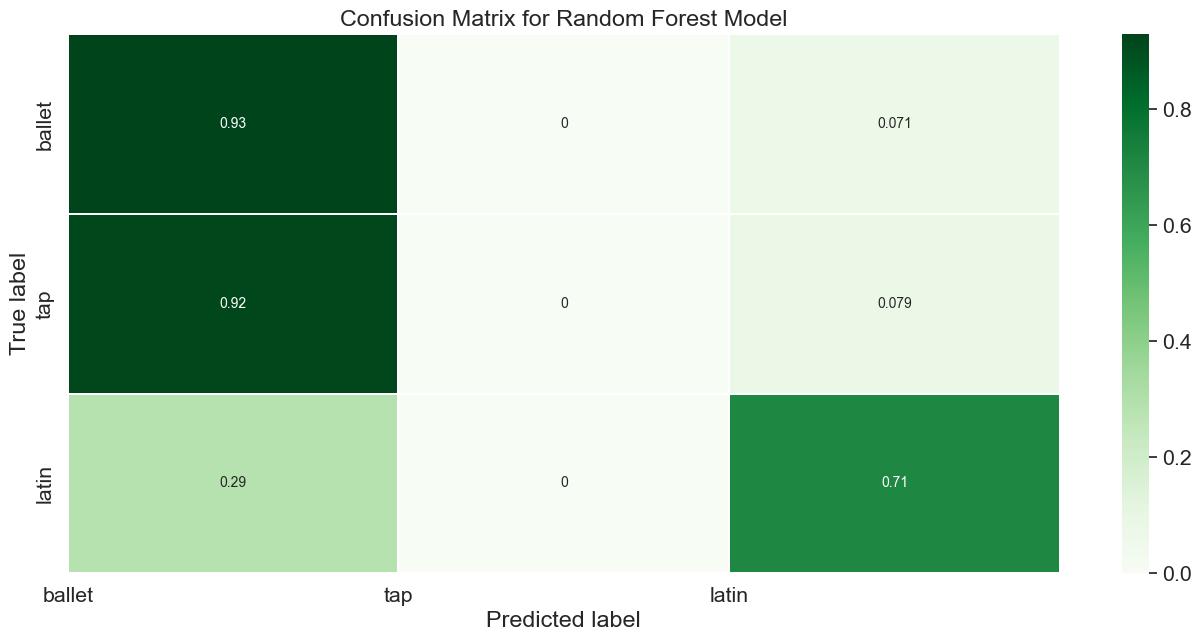

In [203]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ballet', 'tap', 'latin']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [204]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ballet       0.48      0.93      0.63       885
       latin       0.00      0.00      0.00       534
         tap       0.90      0.71      0.80      1374

    accuracy                           0.65      2793
   macro avg       0.46      0.55      0.48      2793
weighted avg       0.60      0.65      0.59      2793



/Users/Shruti/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Shruti/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/Shruti/anaconda3/envs/tf/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

## Gradient Boost Model

In [205]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100,max_depth=5)

# fit the model with the training data
model.fit(X_train_final_flattened_reshaped, y_train)

# predict the target on the train dataset
predict_test = model.predict(X_test_final_flattened_reshaped)
#print('\nTarget on train data',predict_train)

# Accuray Score on train dataset
accuracy_train = accuracy_score(y_test,predict_test)
print('\naccuracy_score on test dataset : ', accuracy_train)


accuracy_score on test dataset :  0.6494808449695668


## Random Forest Model 2

In [206]:
# Initialize the Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train_final_flattened_reshaped, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_final_flattened_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6161833154314358


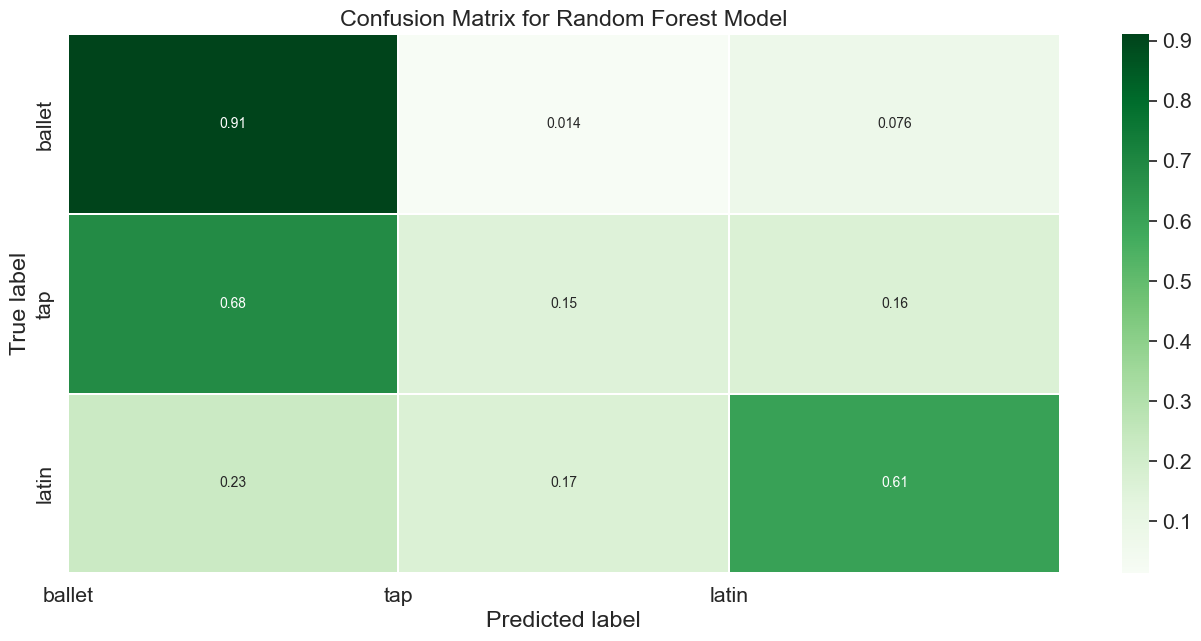

In [207]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['ballet', 'tap', 'latin']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks2, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [208]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      ballet       0.54      0.91      0.68       885
       latin       0.25      0.15      0.19       534
         tap       0.84      0.61      0.71      1374

    accuracy                           0.62      2793
   macro avg       0.55      0.56      0.53      2793
weighted avg       0.64      0.62      0.60      2793



# Neural Net Model

In [ ]:
#Preprocess the y data to be integers instead of strings
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)
print(f'encoded y train data is: {y_train_encoded}')

#Collect label names
label_names = list(label_encoder.classes_)

In [ ]:
def build_model(n_classes,
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of output classes in the dataset.
    hidden_layer_sizes: A list with the number of units in each hidden layer.
    activation: The activation function to use for the hidden layers.
    optimizer: The optimizer to use (SGD, Adam).
    learning_rate: The desired learning rate for the optimizer.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  # YOUR CODE HERE
  #initialize the model
  model = tf.keras.Sequential()

  #Add layer to flatten the image into a vector
  #model.add(keras.layers.Flatten())

  #Add hidden layers to the model
  for hidden_layer_size in hidden_layer_sizes:
    model.add(tf.keras.layers.Dense(units=hidden_layer_size,
                                    activation = activation))
                        
  #Add logistic regression at the end of the model
  model.add(tf.keras.layers.Dense(units=n_classes,
                                  activation = 'softmax'))

  #Select the proper optimizer
  if optimizer == 'Adam':
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate)
  else:
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate = learning_rate)
                            
  #Set the loss and optimizer in the model
  model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                optimizer = optimizer,
                metrics=['accuracy'])
  
  return model

In [ ]:
def train_and_evaluate(X_train, y_train,
                       n_classes,
                       data='digits',
                       hidden_layer_sizes=[],
                       activation='tanh',
                       optimizer='Adam',
                       learning_rate=0.01,
                       num_epochs=5,
                       exp_number = 0):

  # Build the model.
  model = build_model(n_classes=n_classes,
                      hidden_layer_sizes=hidden_layer_sizes,
                      activation=activation,
                      optimizer=optimizer,
                      learning_rate=learning_rate)

  # Train the model.
  print('Training...')
  history = model.fit(
    x=X_train,
    y=y_train,
    epochs=num_epochs,
    batch_size=64,
    validation_split=0.1,
    verbose=0)

  # Retrieve the training metrics (after each train epoch) and the final test
  # accuracy.
  train_accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  plt.plot(train_accuracy, label='train_accuracy_' + str(exp_number))
  plt.plot(val_accuracy, label='validation accuracy_' + str(exp_number))
  plt.xticks(range(num_epochs))
  plt.xlabel('Train epochs')
  plt.legend()
  
  return train_accuracy, val_accuracy, plt.gcf(), model



In [ ]:
# Run the model
train_accuracy, val_accuracy, fig, model = train_and_evaluate(X_train = X_train_flattened_reshaped, y_train = y_train_encoded, 
                                                       n_classes = 3, hidden_layer_sizes = [256,128], activation = 'relu', 
                                                       optimizer = 'Adam', num_epochs = 100, learning_rate = 0.0001)

plt.show

In [ ]:
#Predict outcome for training data
softmax_output = model.predict(X_train_flattened_reshaped)
y_pred_encoded = np.argmax(softmax_output, axis=1)

In [ ]:
# Create confusion matrix on the training data
confusion_matrix = tf.math.confusion_matrix(y_train_encoded, y_pred_encoded)

# Use a heatmap plot to display it.
plt.figure(figsize=(4, 3))
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
ax.set_title('Confusion Matrix on Training Data')
plt.show()

In [ ]:
#Evaluate the accuracy on test data
softmax_output = model.predict(X_test_flattened_reshaped)
predicted_indices = np.argmax(softmax_output, axis=1)

# Convert the encoded integers back into strings
predicted_labels = label_encoder.inverse_transform(predicted_indices)

#Calculate the accuracy score for the test data
accuracy = accuracy_score(y_test, predicted_labels)
print(f'accuracy on the test data is: {accuracy}')    

## Adding in normalization of features for NN

In [ ]:
#Create dictionary for unseparated body part mapping
body_part_labels_unseparated = get_body_part_labels('../Data/densepose/txt/ballet/-5Yp-vToI2E_016_0001.json')
body_part_indx_dict = {}
body_part_mapping_unseparated = {label: i for i, label in enumerate(body_part_labels_unseparated)}

In [ ]:
 def normalize_frame(X_frame): 
    '''Input a frame of dimensions (1,17,2) that contains X and Y information.
    Will return normalized x and y data relative to hip position, normalized
    by hip width'''

    #Pull out x and y values from the frame
    x_values = X_frame[0,:,0]
    y_values = X_frame[0,:,1]

    #Identify hip information.  Calculate the center of the hip for x and y values
    left_hip_x = x_values[body_part_mapping_unseparated['left_hip']]
    right_hip_x = x_values[body_part_mapping_unseparated['right_hip']]
    hip_distance_x = abs(left_hip_x - right_hip_x)
    hip_center_x = min(left_hip_x,right_hip_x) + hip_distance_x/2

    #For cases when there is no distance between hips
    if hip_distance_x == 0:
       return None, hip_distance_x

    left_hip_y = y_values[body_part_mapping_unseparated['left_hip']]
    right_hip_y = y_values[body_part_mapping_unseparated['right_hip']]
    hip_center_y = min(left_hip_y,right_hip_y) + abs(left_hip_y - right_hip_y)/2

    #Center based on hip center and normalized based on hip distance
    x_values_new = (x_values - hip_center_x)/hip_distance_x
    y_values_new = (y_values - hip_center_y)/hip_distance_x

    #Stack the data back into one array of shape (1,17,2)
    normalized_frame = np.stack((x_values_new, y_values_new), axis=-1).reshape(1,17,2)
    return normalized_frame, hip_distance_x

 def normalize_frame_by_box(X_frame): 
    '''Input a frame of dimensions (1,17,2) that contains X and Y information.
    Will return normalized x and y data relative to hip position, normalized
    by hip width'''

    #Pull out x and y values from the frame
    x_values = X_frame[0,:,0]
    y_values = X_frame[0,:,1]

    #Identify hip information.  Calculate the center of the hip for x and y values
    left_hip_x = x_values[body_part_mapping_unseparated['left_hip']]
    right_hip_x = x_values[body_part_mapping_unseparated['right_hip']]
    hip_distance_x = abs(left_hip_x - right_hip_x)
    hip_center_x = min(left_hip_x,right_hip_x) + hip_distance_x/2
    width = max(x_values) - min(x_values)

    left_hip_y = y_values[body_part_mapping_unseparated['left_hip']]
    right_hip_y = y_values[body_part_mapping_unseparated['right_hip']]
    hip_center_y = min(left_hip_y,right_hip_y) + abs(left_hip_y - right_hip_y)/2
    height = max(y_values) - min(y_values)

    #Center based on hip center and normalized based on hip distance
    x_values_new = (x_values - hip_center_x)/width
    y_values_new = (y_values - hip_center_y)/height

    #Stack the data back into one array of shape (1,17,2)
    normalized_frame = np.stack((x_values_new, y_values_new), axis=-1).reshape(1,17,2)
    return normalized_frame, hip_distance_x, width, height


def normalize_data(X_data):
    '''Input a dataset of dimensions (n,1,17,2) that contains X and Y information.
    Will return normalized x and y data relative to hip position, normalized
    by hip width'''

    #Set up emtpy array
    normalized_data = np.empty((0,1,17,2))
    hip_distances = []
    frames_to_drop = []
    widths = []
    heights = []

    #Populate the array with normalized data
    for i in range(len(X_data)):
        new_row, hip_distance, width, height = normalize_frame_by_box(X_train[i])
        if new_row is not None:
            new_row = new_row.reshape(1,1,17,2)
            normalized_data = np.concatenate((normalized_data, new_row), axis = 0)
            hip_distances.append(hip_distance)
            widths.append(width)
            heights.append(height)
        else:
            frames_to_drop.append(i)

    return normalized_data, hip_distances,frames_to_drop, widths, heights

X_train_normalized, hip_distances, frames_to_drop_train, widths, heights = normalize_data(X_train)
X_train_normalized_flattened = X_train_normalized.reshape(X_train_normalized.shape[0],-1)

X_test_normalized, hip_distances_test, frames_to_drop_test, widths_test, heights_test = normalize_data(X_test)
X_test_normalized_flattened = X_test_normalized.reshape(X_test_normalized.shape[0],-1)

y_train_normalized = np.delete(y_train, frames_to_drop_train)
y_test_normalized = np.delete(y_test, frames_to_drop_test)
print(f'Train normalized data shape is {X_train_normalized_flattened.shape}')
print(f'Test normalized data shape is {X_test_normalized_flattened.shape}')
print(f'Train normalized labels shape is {y_train_normalized.shape}')
print(f'Test normalized labels shape is {y_test_normalized.shape}')

#### Train NN

In [ ]:
#Preprocess the y data to be integers instead of strings
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_normalized)
y_test_encoded = label_encoder.fit_transform(y_test_normalized)
print(f'encoded y train data is: {y_train_encoded}')

#Collect label names
label_names = list(label_encoder.classes_)

In [ ]:
# Run the model
train_accuracy, val_accuracy, fig, model = train_and_evaluate(X_train = X_train_normalized_flattened, y_train = y_train_encoded, 
                                                       n_classes = 3, hidden_layer_sizes = [256,128], activation = 'relu', 
                                                       optimizer = 'Adam', num_epochs = 100, learning_rate = 0.001)

plt.show

In [ ]:
#Evaluate the accuracy on test data
softmax_output = model.predict(X_test_normalized_flattened)
predicted_indices = np.argmax(softmax_output, axis=1)

# Convert the encoded integers back into strings
predicted_labels = label_encoder.inverse_transform(predicted_indices)

#Calculate the accuracy score for the test data
accuracy = accuracy_score(y_test, predicted_labels)
print(f'accuracy on the test data is: {accuracy}')   